# Depth Estimation and 3D Scene Reconstruction

By Peyman Hashemi

Feb 2023

Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

import os
import datetime

import open3d as o3d

import cv2

In [3]:
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def before_after(img_a, img_b, name='', vmin=None, vmax=None, effect_name='Processed'):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{name} Original')
    axs[1].set_title(f'{name} {effect_name}')
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

## Load dataset

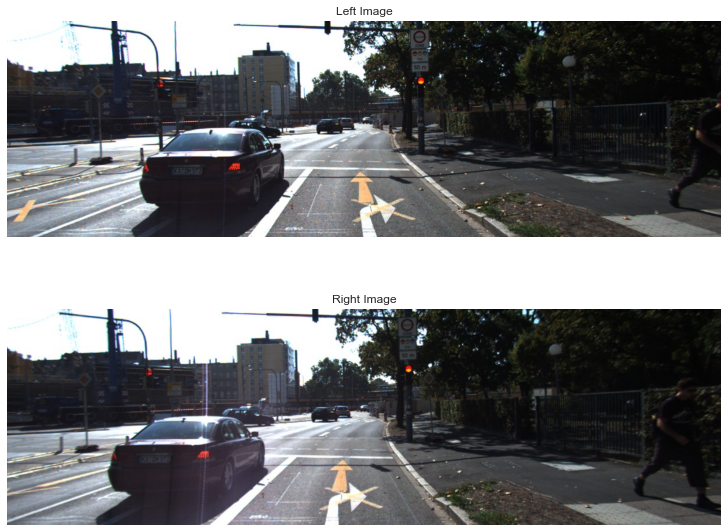

In [4]:
img_L = rgb(cv2.imread('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_02/data/0000000000.jpg'))
img_R = rgb(cv2.imread('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/image_03/data/0000000000.jpg'))

# plot images above each other
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(10,8))
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('Left Image')
axs[1].set_title('Right Image')
axs[0].imshow(img_L)
axs[1].imshow(img_R)
plt.show()
            

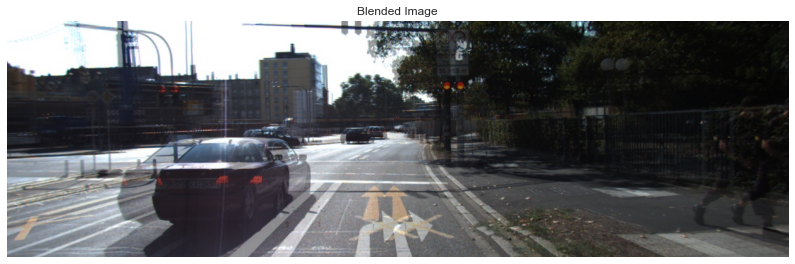

In [5]:
# Blend the two images together
img_blend = cv2.addWeighted(img_L, 0.5, img_R, 0.5, 0)
disp(img_blend, 'Blended Image', s=14)


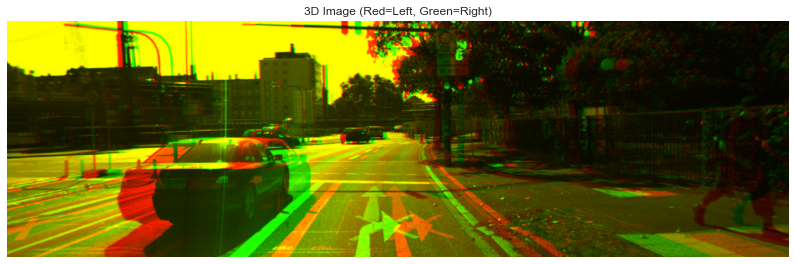

In [6]:
new_image = np.zeros_like(img_L)
new_image[:,:,0] = gray(img_L)
new_image[:,:,1] = gray(img_R)
disp(new_image, '3D Image (Red=Left, Green=Right)', s=14)

## A) Display Point Cloud

In [ ]:
import open3d as o3d
import numpy as np

def conv_rgb(img):
    return img[:, :, ::-1]

def img_to_pointcloud(img, depth):
    rgb = o3d.geometry.Image(img)
    depth = o3d.geometry.Image(depth)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth, convert_rgb_to_intensity=False)
    pc = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    pc.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    o3d.visualization.draw_geometries([pc])

if __name__ == '__main__':
    print(o3d.__version__)
    img = o3d.io.read_image('color.png')
    depth = o3d.io.read_image('depth.png')
    img_to_pointcloud(img, depth)

In [ ]:
from utils import *
import open3d as o3d
scan = load_velo_scan('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/velodyne_points/data/0000000000.bin')
scan = scan[:, :3]
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(scan)
open3d.visualization.draw_geometries([point_cloud])
o3d.visualization.draw_geometries(
                                    [point_cloud],
                                    zoom=0.3412,
                                    front=[0.4257, -0.2125, -0.8795],
                                    lookat=[2.6172, 2.0475, 1.532],
                                    up=[-0.0694, -0.9768, 0.2024])


## B) Display point clouds on img_L

In [7]:
from utils import *

In [8]:
scan = load_velo_scan('kitti_sample/2011_09_29/2011_09_29_drive_0026_sync/velodyne_points/data/0000000000.bin')
scan = scan[:, :3]
scan.shape

(119339, 3)

In [9]:
def project_points_to_camera_2(X):
    # Y = P_rect_xx * R_rect_00 * (R|T)_velo_to_cam * X

    RT_velo_to_cam = np.array([
            [7.755449e-03, -9.999694e-01, -1.014303e-03, -7.275538e-03],
            [2.294056e-03, 1.032122e-03, -9.999968e-01, -6.324057e-02],
            [9.999673e-01, 7.753097e-03, 2.301990e-03, -2.670414e-01],
            [0, 0, 0, 1],
        ])

    R_rect_00 = np.array([
            [9.999478e-01, 9.791707e-03, -2.925305e-03, 0],
            [-9.806939e-03, 9.999382e-01, -5.238719e-03, 0],
            [2.873828e-03, 5.267134e-03, 9.999820e-01, 0],
            [0, 0, 0, 1],
        ])

    P_rect_xx = np.array([
            [7.183351e+02, 0.000000e+00, 6.003891e+02, 4.450382e+01],
            [0.000000e+00, 7.183351e+02, 1.815122e+02, -5.951107e-01],
            [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.616315e-03]
        ])

    # Add ones for homogeneous coordinates X=(x, y, z, 1).T
    X = np.hstack((X, np.ones((X.shape[0], 1))))

    # LiDAR to Image
    #   3x4         4x4         4x4              4xN
    Y = P_rect_xx @ R_rect_00 @ RT_velo_to_cam @ X.T

    # Normalize
    u, v, w = Y[0, :] / Y[2, :], Y[1, :] / Y[2, :], Y[2, :]

    return u, v, w


### Project 3D points to 2D

In [10]:
u, v, w = project_points_to_camera_2(scan)

### Filter points outside of image or behind camera


In [11]:
# before filtering
print(u.shape, v.shape, w.shape)

(119339,) (119339,) (119339,)


In [12]:
mask = (u >= 0) & (u < img_L.shape[1]) & (v >= 0) & (v < img_L.shape[0]) & (w > 0)
u, v, w = u[mask], v[mask], w[mask]

In [13]:
# after filtering
print(u.shape, v.shape, w.shape)

(18575,) (18575,) (18575,)


### Plot using matplotlib

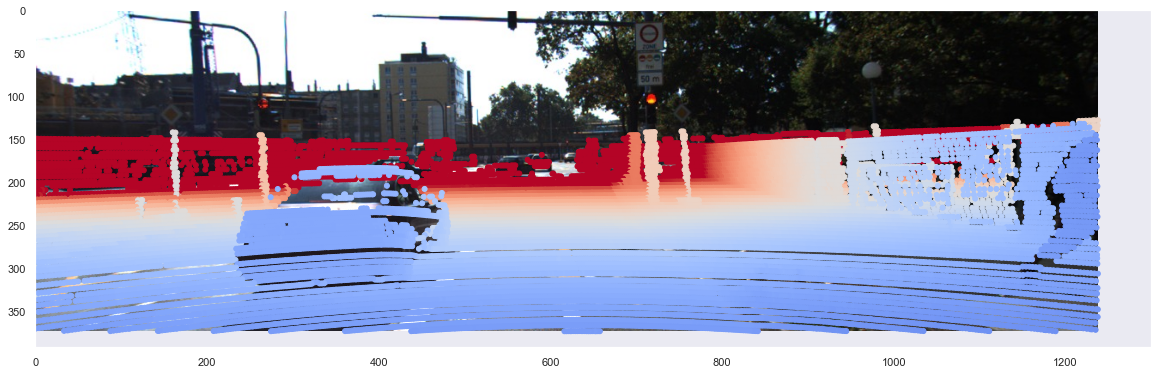

In [14]:
# plot u, v dots on image_L
plt.figure(figsize=(20, 20))
plt.imshow(img_L)

plt.scatter(u, v, s=25, c=w, cmap='coolwarm', vmin=0, vmax=30)
plt.show()

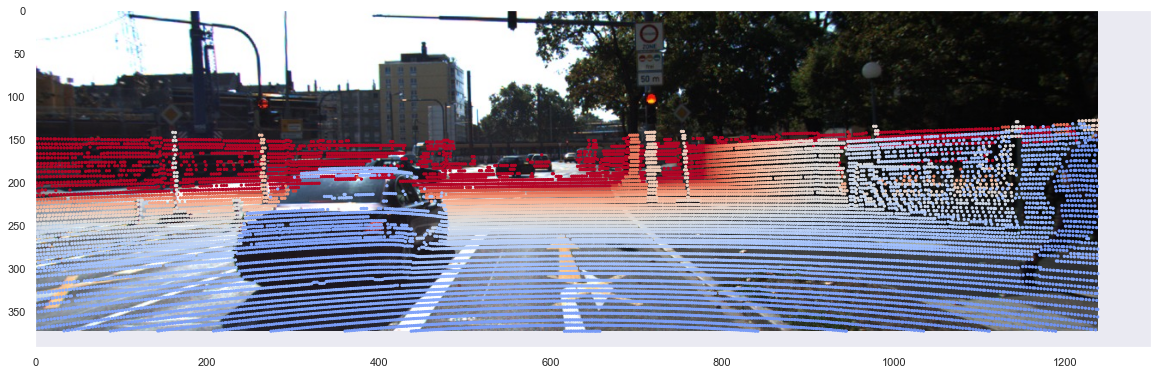

In [15]:
# plot u, v dots on image_L
plt.figure(figsize=(20, 20))
plt.imshow(img_L)

plt.scatter(u, v, s=5, c=w, cmap='coolwarm', vmin=0, vmax=30)
plt.show()

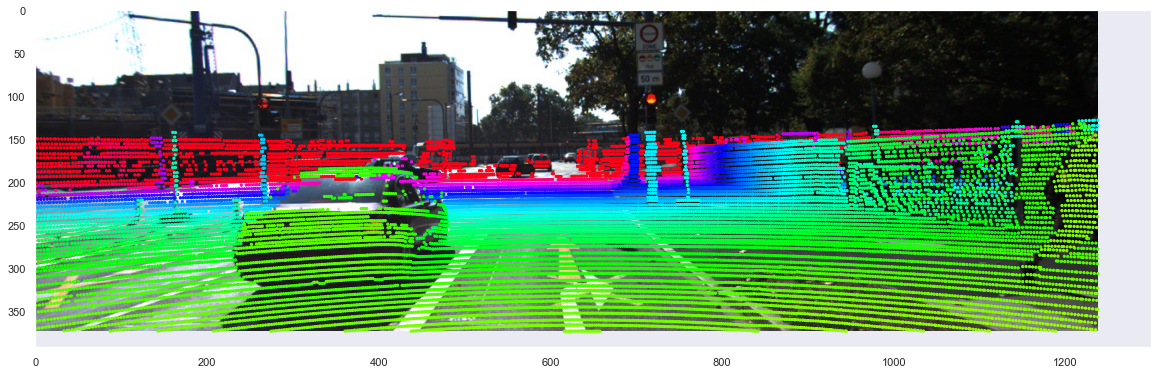

In [16]:
# plot u, v dots on image_L
plt.figure(figsize=(20, 20))
plt.imshow(img_L)

plt.scatter(u, v, s=5, c=w, cmap='hsv', vmin=-6, vmax=40)
plt.show()

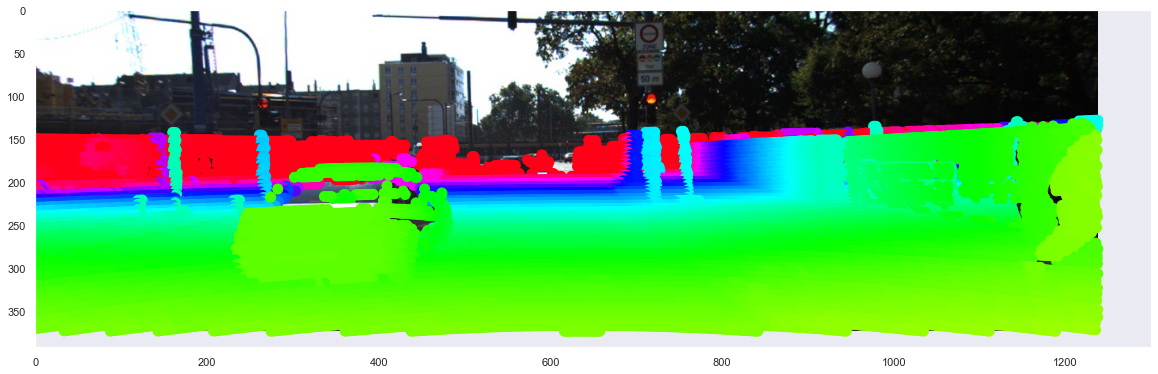

In [17]:
# plot u, v dots on image_L
plt.figure(figsize=(20, 20))
plt.imshow(img_L)

plt.scatter(u, v, s=100, c=w, cmap='hsv', vmin=-6, vmax=40)
plt.show()

### Depth Histogram

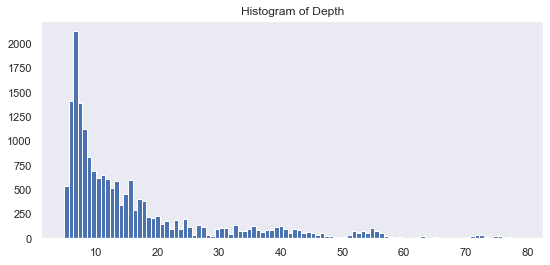

In [18]:
#hist of w
plt.figure(figsize=(9, 4))
plt.hist(w, bins=100)
plt.title('Histogram of Depth')
plt.show()


### Plot using cv2

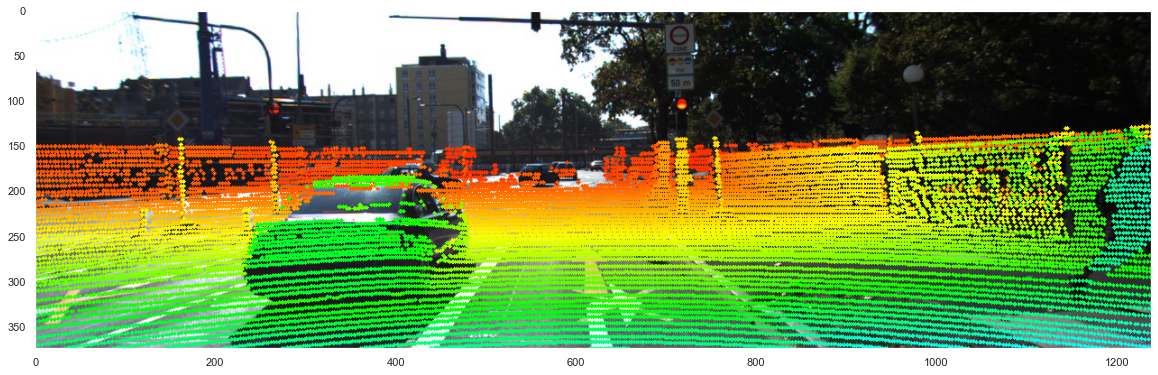

In [19]:
cmap = plt.cm.get_cmap('hsv', 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

img_L_drawn = img_L.copy()

for i in range(w.shape[0]):
    depth = w[i]
    try:
        color = cmap[int(640.0 / depth), :]
        cv2.circle(img_L_drawn, (int(np.round(u[i])),
                            int(np.round(v[i]))),
                    2, color=tuple(color), thickness=-1)
    except:
        pass

plt.figure(figsize=(20, 20))
plt.imshow(img_L_drawn)
plt.xlim(0, img_L.shape[1])
plt.ylim(img_L.shape[0], 0)
plt.show()


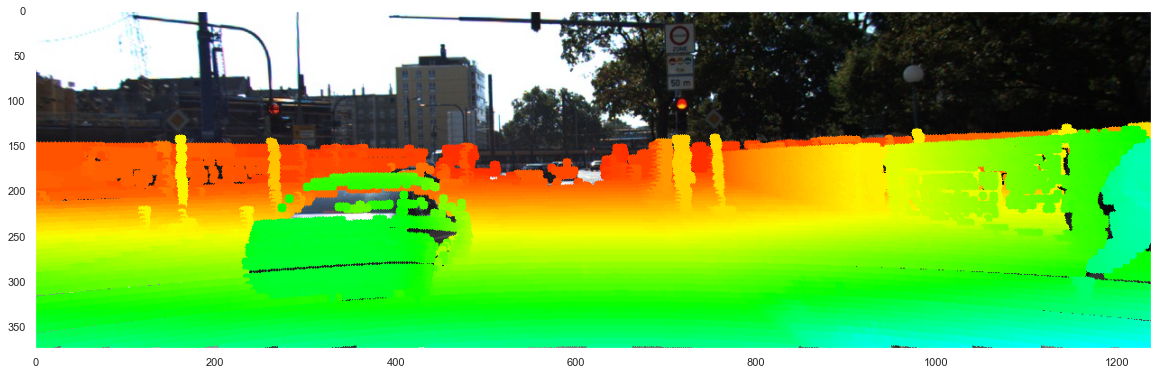

In [20]:
cmap = plt.cm.get_cmap('hsv', 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

img_L_drawn = img_L.copy()

for i in range(w.shape[0]):
    depth = w[i]
    try:
        color = cmap[int(640.0 / depth), :]
        cv2.circle(img_L_drawn, (int(np.round(u[i])),
                            int(np.round(v[i]))),
                    5, color=tuple(color), thickness=-1)
    except:
        pass

plt.figure(figsize=(20, 20))
plt.imshow(img_L_drawn)
plt.xlim(0, img_L.shape[1])
plt.ylim(img_L.shape[0], 0)
plt.show()


## C) Depth map from point cloud (Interpolation)

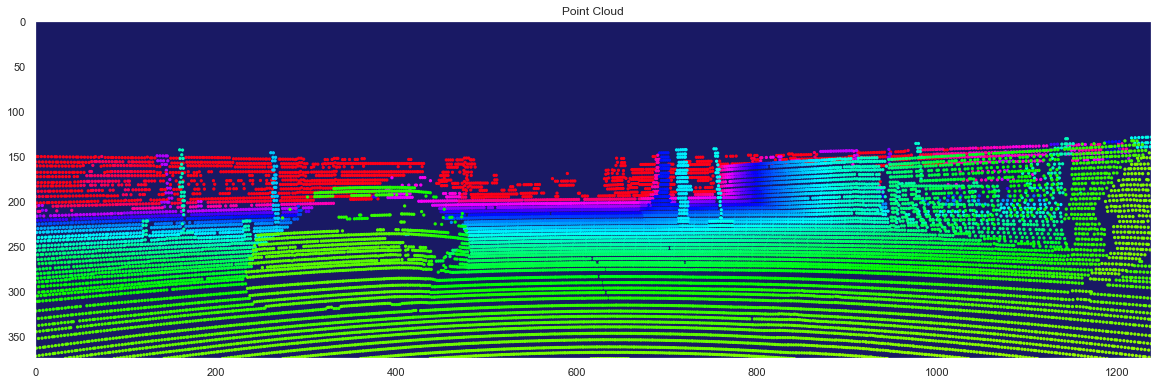

In [21]:
# plot u, v dots on blue bg
plt.figure(figsize=(20, 20))
bg = np.ones_like(img_L) * [25, 25, 100]
plt.scatter(u, v, s=5, c=w, cmap='hsv', vmin=-6, vmax=40)
plt.title("Point Cloud")
plt.imshow(bg)
plt.show()

In [22]:
w.shape, u.shape, v.shape

((18575,), (18575,), (18575,))

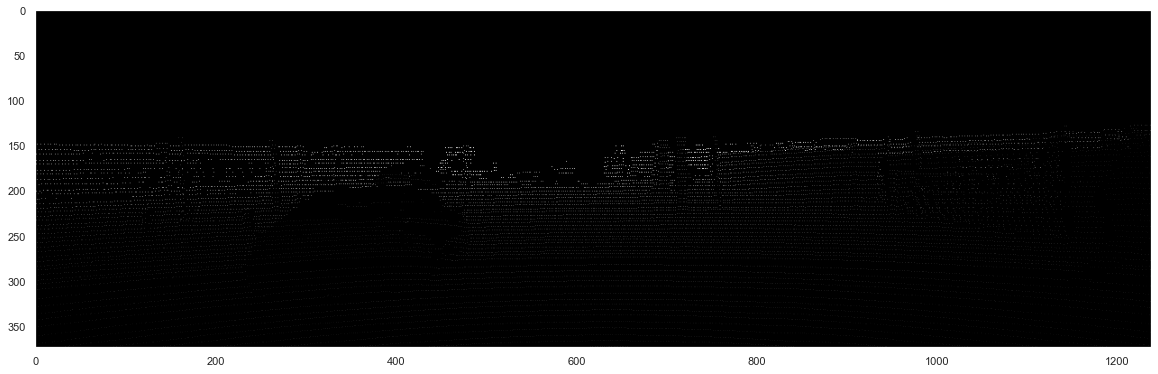

In [23]:
# estimate depth map from point cloud using interpolation
depth_map_pc = np.zeros_like(img_L[:, :, 0], dtype=np.float32) - 1 # init with "-1"
for i in range(w.shape[0]):
    if v[i] < depth_map_pc.shape[0] and u[i] < depth_map_pc.shape[1] and v[i] >= 0 and u[i] >= 0:
        depth_map_pc[int(np.floor(v[i])), int(np.floor(u[i]))] = w[i]

plt.figure(figsize=(20, 20))
plt.imshow(depth_map_pc, cmap='gray', vmin=0, vmax=80)
plt.show()

In [24]:
# interpolate pixels that are -1 with neighbors
depth_map_pc_interpolated = depth_map_pc.copy()
for i in range(depth_map_pc_interpolated.shape[0]):
    for j in range(depth_map_pc_interpolated.shape[1]):
        if depth_map_pc_interpolated[i, j] == -1:
            # find neighbors
            neighbors = []
            if i > 0:
                if depth_map_pc_interpolated[i-1, j] != -1:
                    neighbors.append(depth_map_pc_interpolated[i-1, j])
            if i < depth_map_pc_interpolated.shape[0] - 1:
                if depth_map_pc_interpolated[i+1, j] != -1:
                    neighbors.append(depth_map_pc_interpolated[i+1, j])
            if j > 0:
                if depth_map_pc_interpolated[i, j-1] != -1:
                    neighbors.append(depth_map_pc_interpolated[i, j-1])
            if j < depth_map_pc_interpolated.shape[1] - 1:
                if depth_map_pc_interpolated[i, j+1] != -1:
                    neighbors.append(depth_map_pc_interpolated[i, j+1])
            if len(neighbors) > 0:
                depth_map_pc_interpolated[i, j] = np.mean(neighbors)

In [25]:
depth_map_pc_interpolated

array([[-1.       , -1.       , -1.       , ..., -1.       , -1.       ,
        -1.       ],
       [-1.       , -1.       , -1.       , ..., -1.       , -1.       ,
        -1.       ],
       [-1.       , -1.       , -1.       , ..., -1.       , -1.       ,
        -1.       ],
       ...,
       [ 6.087308 ,  6.1193943,  6.1587553, ...,  5.0700297,  5.1231184,
         5.1487236],
       [ 6.087308 ,  6.103351 ,  6.131053 , ...,  4.869781 ,  4.9964495,
         5.0725865],
       [ 6.087308 ,  6.0953293,  6.113191 , ...,  4.9550953,  4.9757724,
         5.0241795]], dtype=float32)

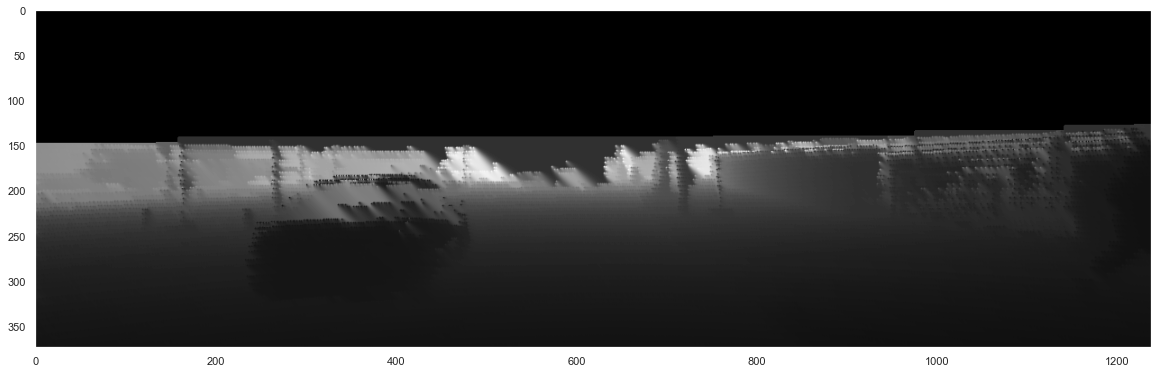

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(depth_map_pc_interpolated, cmap='gray', vmin=0, vmax=80)
plt.show()


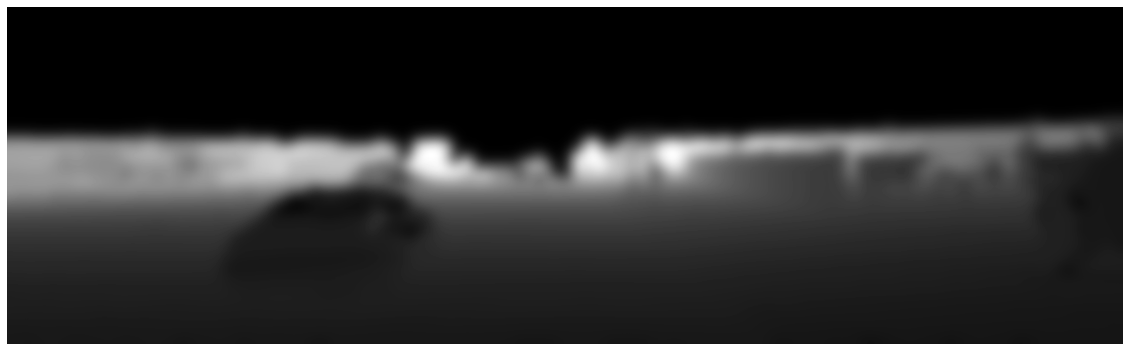

In [28]:
# dilate depth map
kernel = np.ones((5, 5), np.uint8)
# circle kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
depth_map_pc_dilated = cv2.dilate(uint8ify(depth_map_pc.copy()), kernel, iterations=1)
# gaussian blur
depth_map_pc_dilated = cv2.GaussianBlur(depth_map_pc_dilated, (51, 51), 0)


disp(depth_map_pc_dilated, s=20)

In [29]:
depth_map_pc

array([[-1.      , -1.      , -1.      , ..., -1.      , -1.      ,
        -1.      ],
       [-1.      , -1.      , -1.      , ..., -1.      , -1.      ,
        -1.      ],
       [-1.      , -1.      , -1.      , ..., -1.      , -1.      ,
        -1.      ],
       ...,
       [-1.      , -1.      , -1.      , ..., -1.      , -1.      ,
        -1.      ],
       [-1.      , -1.      , -1.      , ...,  4.869781, -1.      ,
        -1.      ],
       [-1.      , -1.      , -1.      , ..., -1.      , -1.      ,
        -1.      ]], dtype=float32)

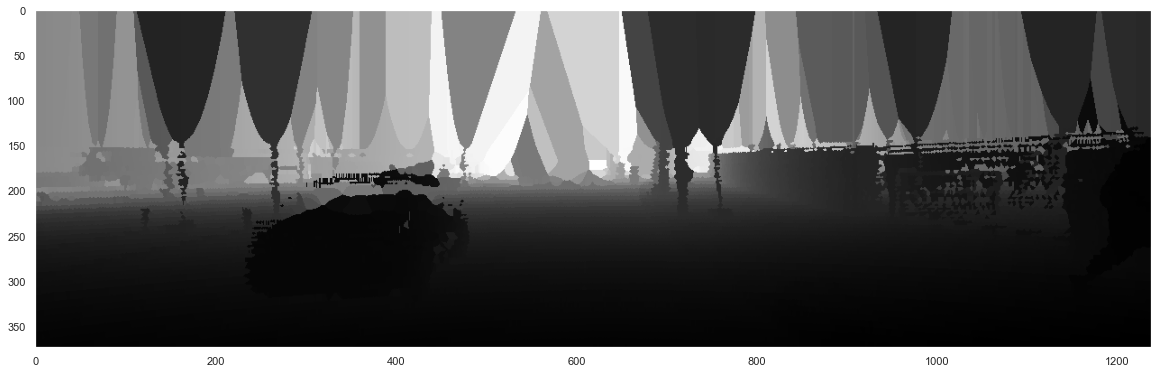

In [43]:
# interpolate using grid data scipy
from scipy.interpolate import griddata

# get all non -1 values
valid = depth_map_pc != -1
# print(valid)
points = np.where(valid)
values = depth_map_pc[valid]

U, V = np.meshgrid(np.arange(depth_map_pc.shape[1]), np.arange(depth_map_pc.shape[0]))

# interpolate
depth_map_pc_interpolated_griddata = griddata(points, values, (V, U), method='nearest')

# reshape
depth_map_pc_interpolated_griddata = depth_map_pc_interpolated_griddata.reshape(depth_map_pc.shape)

plt.figure(figsize=(20, 20))
plt.imshow(depth_map_pc_interpolated_griddata, cmap='gray')
plt.show()


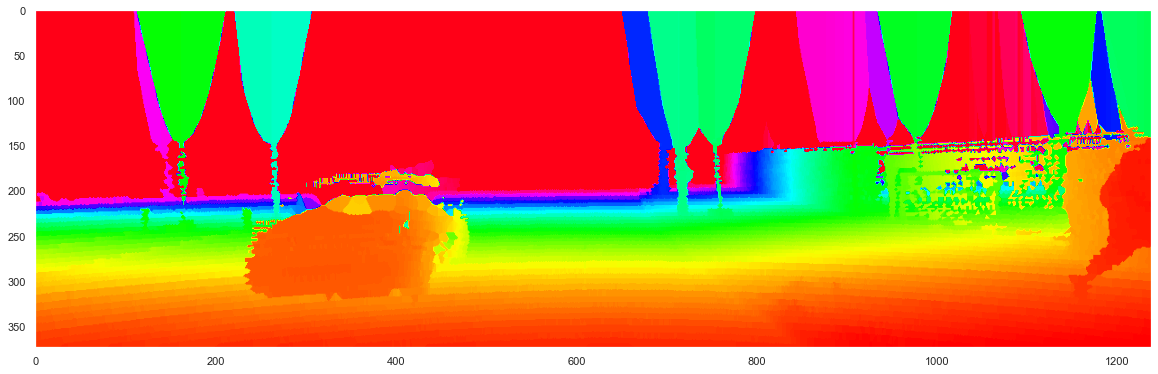

In [31]:
plt.figure(figsize=(20, 20))
plt.imshow(depth_map_pc_interpolated_griddata, cmap='hsv', vmin=5, vmax=35)
plt.show()

In [32]:
np.invert(valid)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

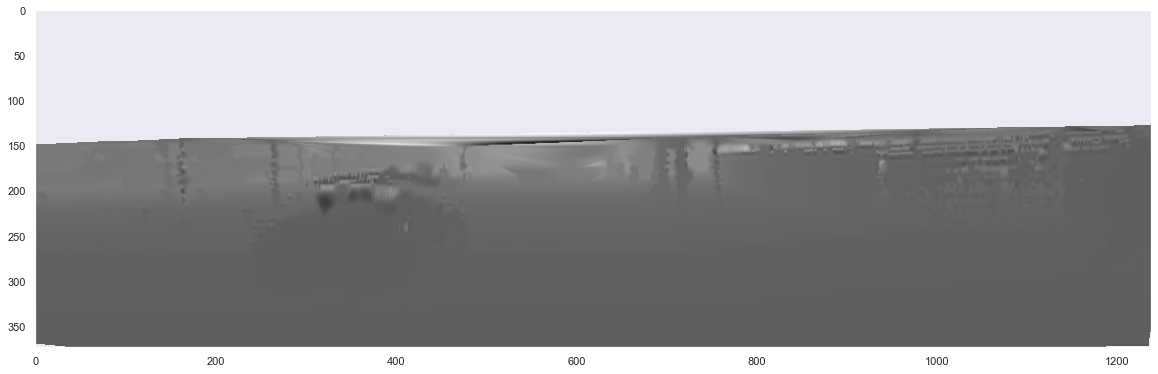

In [33]:
# interpolate using grid data scipy
from scipy.interpolate import griddata

# get all non -1 values
valid = depth_map_pc != -1
# print(valid)
points = np.where(valid)
values = depth_map_pc[valid]

U, V = np.meshgrid(np.arange(depth_map_pc.shape[1]), np.arange(depth_map_pc.shape[0]))

# depth_map_pc[np.invert(valid)] = 0

# interpolate
depth_map_pc_interpolated_griddata = griddata(points, values, (V, U), method='cubic')

# reshape
depth_map_pc_interpolated_griddata = depth_map_pc_interpolated_griddata.reshape(depth_map_pc.shape)

plt.figure(figsize=(20, 20))
plt.imshow(depth_map_pc_interpolated_griddata, cmap='gray')
plt.show()


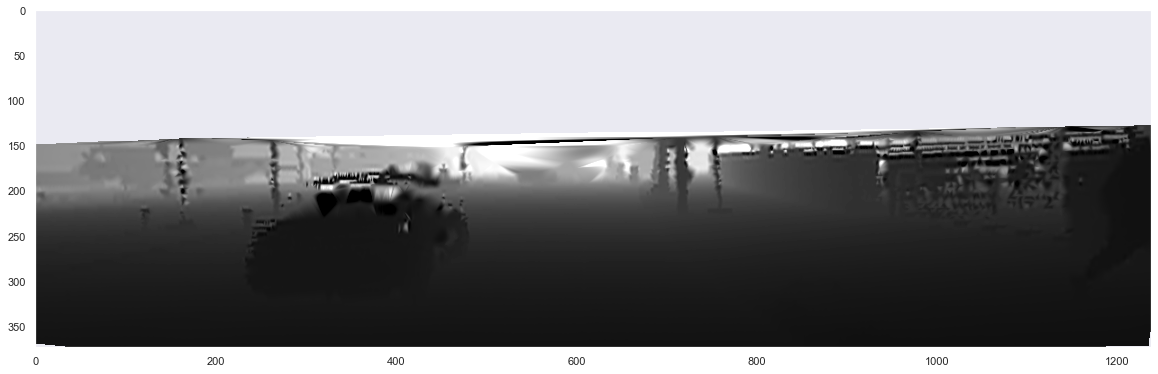

In [34]:
plt.figure(figsize=(20, 20))
plt.imshow(depth_map_pc_interpolated_griddata, cmap='gray', vmin=0, vmax=80)
plt.show()

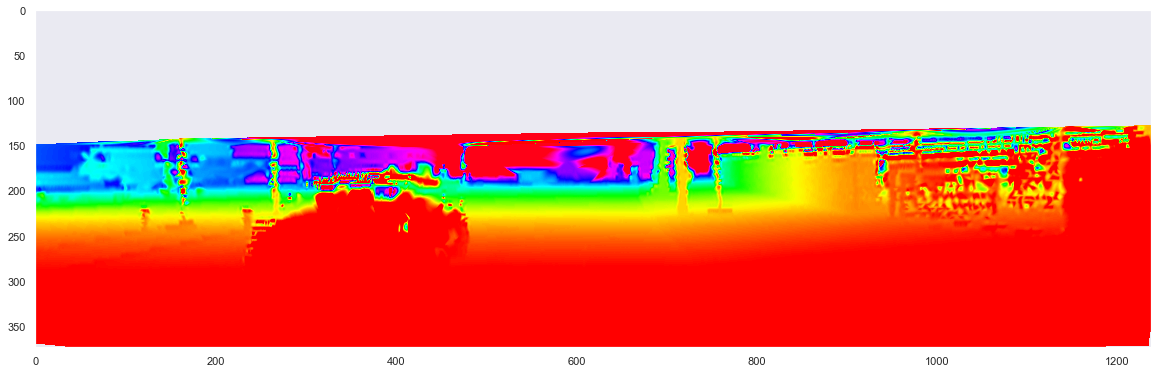

In [35]:
plt.figure(figsize=(20, 20))
plt.imshow(depth_map_pc_interpolated_griddata, cmap='hsv', vmin=10, vmax=65)
plt.show()

## D) Stereo depth map

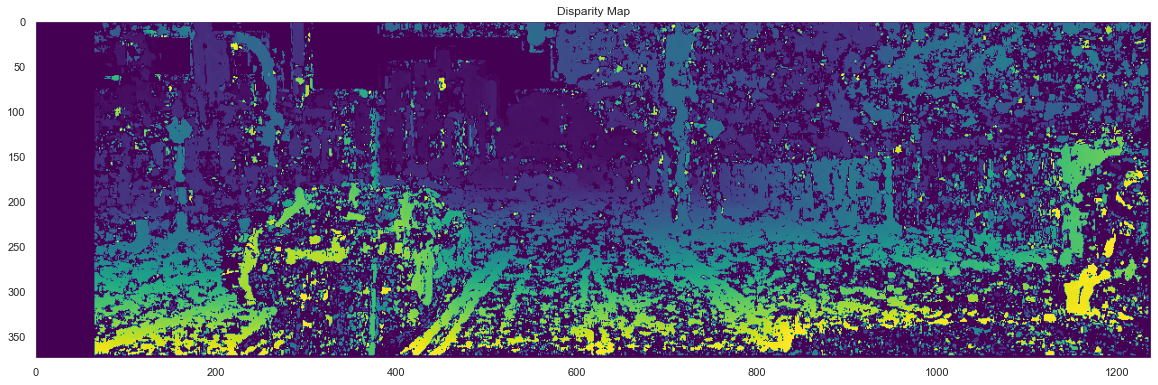

In [36]:
stereo = cv2.StereoBM_create(numDisparities=0, blockSize=7)
disparity = stereo.compute(gray(img_L), gray(img_R))
plt.figure(figsize=(20, 7))
plt.title('Disparity Map')
plt.imshow(disparity,'viridis')
# plt.colorbar()
plt.show()

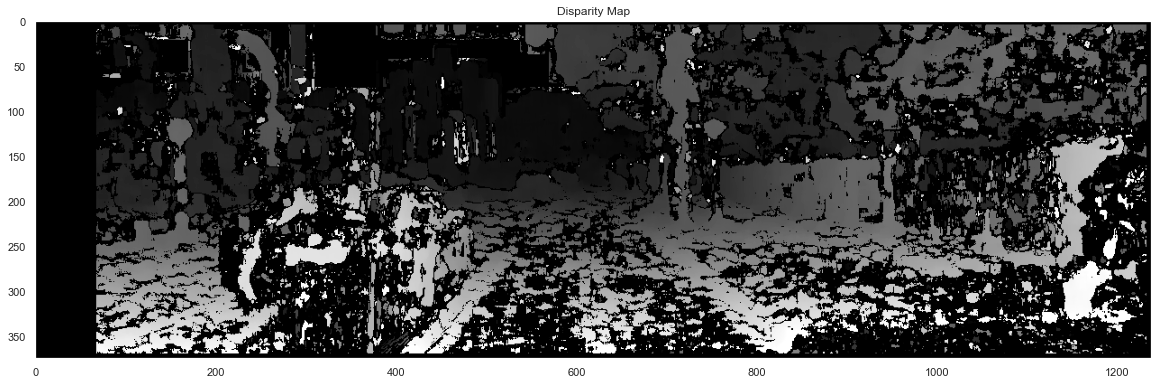

In [37]:
stereo = cv2.StereoBM_create(numDisparities=0, blockSize=11)
disparity = stereo.compute(gray(img_L), gray(img_R))
plt.figure(figsize=(20, 7))
plt.title('Disparity Map')
plt.imshow(disparity,'gray')
# plt.colorbar()
plt.show()

In [46]:
# Save rgb and depth images for creating point cloud
cv2.imwrite('color.png', bgr(img_L))
cv2.imwrite('depth.png', uint8ify(depth_map_pc_interpolated_griddata))


True